In [1]:
import pandas as pd
from dateutil.parser import parse
from datetime import datetime
from datetime import timedelta

key_words = ["U.S.-China trade and COVID-19","Unfair trade and intellectual property rights","U.S.-China trade and tariffs","U.S.-China trade war and trade barriers","U.S.-China trade war and protectionism","China and the world order","China and national Security","presidential election and trade war"]
key_words_number = len(key_words)
websites = ["Huffpost","the Washington Post","Fox News","Wall Street journal"]
websites_number = len(websites)

In [2]:
def merge_data_website(website):
    pieces = []
    for i in range(key_words_number):
        file_path = "~/data/data_%s_%s.json"%(website,key_words[i])
        frame = pd.read_json(file_path)
        pieces.append(frame)
    data = pd.concat(pieces, ignore_index=True)
    return data

In [3]:
websites_merge_data = []
for website in websites:
    data = merge_data_website(website).drop_duplicates(['content'])
    websites_merge_data.append(data)

/home/congw/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1218: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [4]:
websites_merge_data[0] = websites_merge_data[0].drop([0,9,11])

In [5]:
pd.set_option('max_row',1000)
pd.set_option('max_columns',500)

In [6]:
websites_merge_data[1] = websites_merge_data[1].drop([3,7,44])

In [7]:
websites_merge_data[3] = websites_merge_data[3].drop([145])

In [8]:
def del_comment(x):
    L = x.split()
    if len(L)>0:
        return L[0]
    return "0"

In [9]:
websites_merge_data[1].comment = websites_merge_data[1].comment.map(del_comment)

In [10]:
def del2_comment(x):
    if len(x)==0:
        return 0
    x=x.replace('(','')
    x=x.replace(')','')
    return x

In [11]:
websites_merge_data[2].comment = websites_merge_data[2].comment.map(del2_comment)

In [16]:
def time_transform(x):
    start = datetime(2020, 8, 1)
    if x.split()[-1]=="ago":
        days_ago = x.split()[0]
        date_str = start-timedelta(int(days_ago))
        return date_str
    else:
        return parse(x)

websites_merge_data[2].date = websites_merge_data[2].date.map(time_transform)

In [17]:
for i,web in enumerate(websites_merge_data):
    web.to_excel("Data-%s.xlsx"%websites[i])

In [18]:
def count_week(website):
    return website.set_index('date').resample('W-SUN').count().url.reset_index()

count_weeks=[]
for i in range(websites_number):
    CW = count_week(websites_merge_data[i]).rename(columns={"url":"number"})
    count_weeks.append(CW)

def topic_count_week(website):
    return website.set_index('date').groupby('topic').resample('W-SUN').count().url.reset_index()

count_topic_weeks=[]
for i in range(websites_number):
    CTW = topic_count_week(websites_merge_data[i]).rename(columns={"url":"number"})
    count_topic_weeks.append(CTW)

import numpy as np

dn = pd.merge(pd.merge(pd.merge(count_weeks[0],count_weeks[1],on='date'),count_weeks[2],on='date'),count_weeks[3],on='date')

dn.columns = ["date"]+websites

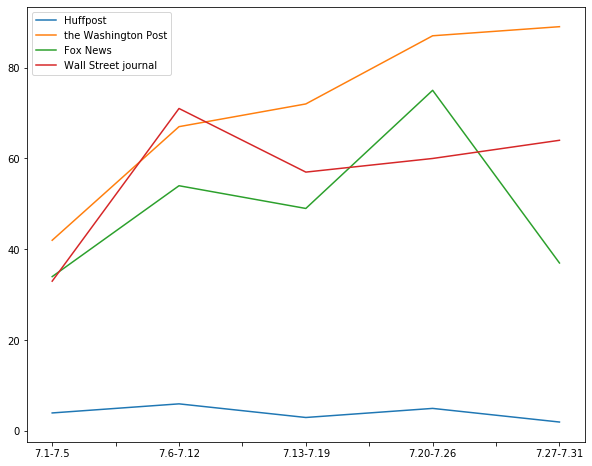

In [19]:
date_range=['7.1-7.5','7.6-7.12','7.13-7.19','7.20-7.26','7.27-7.31']

dn = dn.set_axis(date_range)

dn = dn.drop('date',axis=1)

dn.plot(figsize=(10,8))

In [20]:
def change_format(df):
    return df.set_index(['date','topic']).unstack().fillna(0)['number']

change_format(count_topic_weeks[0]).to_excel("e.xlsx")

for i,df in enumerate(count_topic_weeks):
    change_format(df).to_excel("Topic-%s.xlsx"%websites[i])